In [27]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

print(f"Project root: {project_root}")
print(f"Python path modified: {str(project_root) in sys.path}")

try:
    import client
    import config
    import models
    import parsers
    import nlp
    print("All project modules are now accessible")
except ModuleNotFoundError as e:
    print(f"Module import failed: {e}")
    raise

Project root: /Users/kat/Desktop/pinned/ginkgo
Python path modified: True
All project modules are now accessible


In [28]:
import sys
from pathlib import Path
import json
from collections import Counter

from client.arxiv import ArXivClient
from client.grobid import GROBIDClient
from models.grobid import Form, File
from parsers.tei import Parser
from config.llm import LangExtractConfig, GeminiConfig
from config.nlp import NLPConfig
from nlp.structural import SectionProcessor
from nlp.semantic import EntityExtractor
from nlp.syntactic import parse
from utils.clean_text import preprocess_section

from nlp.entity_filter import (
    normalize_text,
    should_merge,
    filter_pipeline,
    analyze_impact,
    nlp,
    FilterConfig
)

In [29]:
arxiv_id = "1810.04805"
output_dir = Path("output")
output_dir.mkdir(exist_ok=True)

In [30]:
arxiv_client = ArXivClient()
metadata = arxiv_client.get_metadata(arxiv_id)
pdf_path = output_dir / f"{arxiv_id}.pdf"
arxiv_client.download_pdf(arxiv_id, str(pdf_path))

In [31]:
grobid_client = GROBIDClient()
with open(pdf_path, "rb") as f:
    pdf_bytes = f.read()

form = Form(
    file=File(payload=pdf_bytes, file_name=f"{arxiv_id}.pdf"),
    consolidate_citations=1,
    consolidate_header=1,
    segment_sentences=True
)

response = grobid_client.process_pdf(form)
tei_path = output_dir / f"{arxiv_id}.tei.xml"
tei_path.write_bytes(response.content)

121974

In [32]:
parser = Parser(response.content)
article = parser.parse()

In [33]:
sections_data = []
for section in article.sections:
    section_text = ""
    for paragraph in section.paragraphs:
        section_text += paragraph.plain_text + " "
    
    clean_text = preprocess_section(section_text.strip())
    sections_data.append({
        "title": section.title,
        "raw_text": section_text.strip(),
        "clean_text": clean_text
    })

In [34]:
langextract_config = LangExtractConfig()
gemini_config = GeminiConfig()
nlp_config = NLPConfig()

In [35]:
from config.nlp import normalize_section

extractor = EntityExtractor(langextract_config)
all_entities = []

for section_data in sections_data:
    normalized_title = normalize_section(section_data["title"], nlp_config.patterns)
    section_config = nlp_config.sections.get(normalized_title, nlp_config.sections["default"])
    
    section_doc = nlp(section_data["clean_text"])
    
    section_entities = extractor.extract(section_data["clean_text"], section_config)
    
    entities_with_context = extractor.convert_to_spans(section_entities, section_doc, context_size=1)
    
    serializable_entities = []
    for entity in entities_with_context:
        entity_copy = dict(entity)
        del entity_copy["span"]
        entity_copy["section"] = section_data["title"]
        serializable_entities.append(entity_copy)
    
    title = section_data["title"].replace(" ", "_").replace("/", "_")
    section_path = output_dir / f"{arxiv_id}_{title}_entities.json"
    section_path.write_text(json.dumps(serializable_entities, indent=2))
    
    all_entities.extend(serializable_entities)

In [36]:
full_clean_text = "\n\n".join(s["clean_text"] for s in sections_data)
full_text_path = output_dir / f"{arxiv_id}_full_text.txt"
full_text_path.write_text(full_clean_text)

all_entities_path = output_dir / f"{arxiv_id}_all_entities.json"
all_entities_json = json.dumps(all_entities, indent=2)
all_entities_path.write_text(all_entities_json)

print(f"Full text saved to: {full_text_path}")
print(f"All entities saved to: {all_entities_path}")

Full text saved to: output/1810.04805_full_text.txt
All entities saved to: output/1810.04805_all_entities.json


In [37]:
arxiv_id = "1810.04805"
output_dir = Path("output")

all_entities_path = output_dir / f"{arxiv_id}_all_entities.json"
full_text_path = output_dir / f"{arxiv_id}_full_text.txt"

print(f"Loading entities from: {all_entities_path}")
with open(all_entities_path) as f:
    all_entities = json.load(f)

print(f"Loading and processing full text from: {full_text_path}")
full_text = full_text_path.read_text()
doc = nlp(full_text)
print("spaCy Doc object created.")

Loading entities from: output/1810.04805_all_entities.json
Loading and processing full text from: output/1810.04805_full_text.txt
spaCy Doc object created.


In [51]:
extractor = EntityExtractor(langextract_config)
entities_with_spans = extractor.convert_to_spans(all_entities, doc, context_size=1)

print(f"Total entities: {len(all_entities)}")
print(f"Entities with valid spans: {len(entities_with_spans)}")

serializable_entities = []
for entity in entities_with_spans:
    entity_copy = dict(entity)
    entity_copy["span_text"] = entity_copy["text"]
    del entity_copy["span"]
    serializable_entities.append(entity_copy)

entities_with_spans_path = output_dir / f"{arxiv_id}_entities_with_context.json"
with open(entities_with_spans_path, "w") as f:
    json.dump(serializable_entities, f, indent=2)

print(f"Entities with context saved to: {entities_with_spans_path}")


Total entities: 459
Entities with valid spans: 459
Entities with context saved to: output/1810.04805_entities_with_context.json


In [39]:
config = FilterConfig(
    min_freq=1,
    exclude_other=True,
    use_fuzzy=True,
    top_k=50,
    window_size=10,
    pagerank_alpha=0.85
)

print(f"\nRunning pipeline with config: window_size={config.window_size}")

filtered_entities = filter_pipeline(
    all_entities, 
    doc,
    config=config
)


Running pipeline with config: window_size=10


In [40]:
for entity in filtered_entities:
    if 'span_text' not in entity:
        entity['span_text'] = entity['text']


In [41]:
def print_results(entities: list[dict], top_n: int = 50):
    type_dist = Counter(e["type"] for e in entities)
    print(f"Type distribution: {dict(type_dist)}\n")
    
    print(f"Top {min(top_n, len(entities))} entities:")
    for i, e in enumerate(entities[:top_n], 1):
        score = e.get("pr_score", 0)
        print(f"  {i:2d}. {e['text']:<40} {e['type']:<8} {score:.4f}")

In [42]:
print_results(filtered_entities)

Type distribution: {'method': 10, 'task': 15, 'dataset': 25}

Top 50 entities:
   1. BERT                                     method   0.0677
   2. fine-tuning                              task     0.0598
   3. Open AI GPT                              method   0.0465
   4. NER                                      method   0.0358
   5. question answering                       task     0.0291
   6. NLI                                      task     0.0270
   7. classification                           task     0.0248
   8. training data                            dataset  0.0230
   9. ELMo                                     method   0.0226
  10. MNLI                                     dataset  0.0200
  11. SQuAD                                    dataset  0.0177
  12. next sentence prediction                 task     0.0155
  13. MRPC                                     dataset  0.0149
  14. Masked LM                                method   0.0141
  15. named entity recognition         

In [43]:
impact = analyze_impact(all_entities, filtered_entities)
print(f"\nReduction: {impact['reduction_pct']:.1f}% ({impact['original_count']} -> {impact['filtered_count']})")


Reduction: 89.1% (459 -> 50)


In [44]:
sentences = [sent.text for sent in doc.sents]
print(f"Document has {len(sentences)} sentences")

Document has 269 sentences


In [45]:
from nlp.candidates.npmi import NPMI

npmi = NPMI(tau=0.15, min_cooc=1)
npmi_candidates = npmi.select(filtered_entities, sentences)

print(f"NPMI selected {len(npmi_candidates)} candidate pairs")
stats = npmi.stats(npmi_candidates)
for k, v in stats.items():
    if isinstance(v, float):
        print(f"  {k}: {v:.3f}")
    else:
        print(f"  {k}: {v}")

NPMI selected 91 candidate pairs
  n_pairs: 91
  mean: 0.499
  median: 0.483
  max: 1.000
  min: 0.177
  tau: 0.150


In [46]:
from nlp.candidates.collocation import Collocation

entity_dict = {e['text']: e for e in filtered_entities}

collocation = Collocation(min_cooc=1, max_sent_dist=5)
collocation_candidates = collocation.filter(npmi_candidates, entity_dict)

print(f"\nCollocation filtered to {len(collocation_candidates)} candidates")
coll_stats = collocation.stats(collocation_candidates)
for k, v in coll_stats.items():
    if isinstance(v, float):
        print(f"  {k}: {v:.3f}")
    else:
        print(f"  {k}: {v}")


Collocation filtered to 28 candidates
  n_pairs: 28
  type_pass_rate: 1.000
  avg_sent_dist: 3.000
  avg_cooc: 1.393
  min_cooc: 1
  max_sent_dist: 5


In [47]:
print("\nTop 20 candidate pairs:")
for i, c in enumerate(collocation_candidates[:20], 1):
    print(f"{i:2d}. {c.e1:30s} ↔ {c.e2:30s}")
    print(f"    NPMI: {c.npmi:.3f} | Co-occ: {c.n_cooc} | Sent dist: {c.sent_distance}")


Top 20 candidate pairs:
 1. LSTMs                          ↔ predict a single word         
    NPMI: 1.000 | Co-occ: 1 | Sent dist: 0
 2. LSTMs                          ↔ sentiment analysis            
    NPMI: 0.876 | Co-occ: 1 | Sent dist: 0
 3. LTR                            ↔ token predictions             
    NPMI: 0.680 | Co-occ: 1 | Sent dist: 4
 4. ELMo                           ↔ LSTMs                         
    NPMI: 0.628 | Co-occ: 1 | Sent dist: 5
 5. ELMo                           ↔ predict a single word         
    NPMI: 0.628 | Co-occ: 1 | Sent dist: 5
 6. ELMo                           ↔ ESIM+ELMo                     
    NPMI: 0.628 | Co-occ: 1 | Sent dist: 3
 7. BiLSTM                         ↔ GLUE tasks                    
    NPMI: 0.607 | Co-occ: 1 | Sent dist: 3
 8. paraphrasing                   ↔ sentence pairs                
    NPMI: 0.588 | Co-occ: 1 | Sent dist: 1
 9. ESIM+ELMo                      ↔ Open AI GPT                   
    NPMI: 0.542 | C

In [48]:
from nlp.relations.embeddings import EntityEmbeddings

embedder = EntityEmbeddings(
    model_name="all-MiniLM-L6-v2",
    batch_size=32,
    normalize=True
)

entity_texts = [e['text'] for e in filtered_entities]
embeddings = embedder.compute(entity_texts)

print(f"Computed embeddings: shape {embeddings.shape}")
print(f"Embedding dimension: {embedder.dim()}")

Computed embeddings: shape (50, 384)
Embedding dimension: 384


In [ ]:
from nlp.relations.explicit import Explicit, find_entity_span
from config.llm import GeminiConfig

gemini_config = GeminiConfig()

explicit_extractor = Explicit(
    config=gemini_config,
    encoder_model='all-mpnet-base-v2',
    damping=0.9,
    max_iter=200,
    conv_iter=10
)


explicit_relations = explicit_extractor.discover(
    npmi_candidates,
    sentences,
    filtered_entities
)

print(f"Discovered {len(explicit_relations)} explicit relations")
explicit_stats = explicit_extractor.stats(explicit_relations)
for k, v in explicit_stats.items():
    if isinstance(v, float):
        print(f"  {k}: {v:.3f}")
    else:
        print(f"  {k}: {v}")

Discovered 9 explicit relations
  n_explicit: 9
  mean_confidence: 0.133
  median_confidence: 0.100
  mean_support: 1.333
  rel_type_dist: {'uses': 4, 'related': 4, 'evaluates': 1}


In [50]:
print("\nTop explicit relations:")
for i, rel in enumerate(explicit_relations[:10], 1):
    print(f"{i:2d}. {rel.e1:20s} --[{rel.rel_type:10s}]--> {rel.e2:20s}")
    print(f"    Confidence: {rel.confidence:.3f} | Support: {rel.n_supporting} sentences")
    print(f"    Exemplar: {rel.exemplar}")


Top explicit relations:
 1. Books Corpus         --[uses      ]--> Wikipedia           
    Confidence: 0.200 | Support: 2 sentences
    Exemplar: use the [ENT1] (800M words) and English [ENT2]
 2. paraphrasing         --[related   ]--> question answering  
    Confidence: 0.200 | Support: 2 sentences
    Exemplar: include sentence-level tasks such as natural language inference and [ENT1], which aim to predict the relationships between sentences by analyzing them holistically, as well as token-level tasks such as named entity recognition and [ENT2]
 3. named entity recognition --[related   ]--> question answering  
    Confidence: 0.200 | Support: 2 sentences
    Exemplar: include sentence-level tasks such as natural language inference and paraphrasing, which aim to predict the relationships between sentences by analyzing them holistically, as well as token-level tasks such as [ENT1] and [ENT2]
 4. LSTMs                --[uses      ]--> predict a single word
    Confidence: 0.100 | Su

In [52]:
from nlp.relations.implicit import ImplicitCluster

explicit_pairs = set()
for r in explicit_relations:
    e1, e2 = r.e1, r.e2
    if e1 < e2:
        explicit_pairs.add((e1, e2))
    else:
        explicit_pairs.add((e2, e1))

implicit_cluster = ImplicitCluster(
    k=5,
    tau_sim=0.70,
    tau_b=2
) # NOTE: values were arbitrarily set, hence "Discovered 0 implicit relations"

implicit_relations = implicit_cluster.infer(
    filtered_entities,
    embeddings,
    explicit_pairs
)

print(f"Discovered {len(implicit_relations)} implicit relations")
implicit_stats = implicit_cluster.stats(implicit_relations)
for k, v in implicit_stats.items():
    if isinstance(v, float):
        print(f"  {k}: {v:.3f}")
    else:
        print(f"  {k}: {v}")

Discovered 0 implicit relations
  n_implicit: 0
  mean_confidence: 0.000
  median_confidence: 0.000
  mean_bridges: 0.000
  k: 5
  tau_b: 2


In [53]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

sim_matrix = cosine_similarity(embeddings)
np.fill_diagonal(sim_matrix, 0)

upper_triangle = np.triu(sim_matrix, k=1)
non_zero_sims = upper_triangle[upper_triangle > 0]

print(f"Similarity statistics:")
print(f"  Mean: {non_zero_sims.mean():.3f}")
print(f"  Median: {np.median(non_zero_sims):.3f}")
print(f"  75th percentile: {np.percentile(non_zero_sims, 75):.3f}")
print(f"  90th percentile: {np.percentile(non_zero_sims, 90):.3f}")
print(f"  Max: {non_zero_sims.max():.3f}")

high_sim_pairs = np.sum(upper_triangle > 0.70)
medium_sim_pairs = np.sum(upper_triangle > 0.50)
print(f"\nPairs with similarity > 0.70: {high_sim_pairs}")
print(f"Pairs with similarity > 0.50: {medium_sim_pairs}")

Similarity statistics:
  Mean: 0.197
  Median: 0.170
  75th percentile: 0.271
  90th percentile: 0.363
  Max: 0.859

Pairs with similarity > 0.70: 6
Pairs with similarity > 0.50: 27


In [67]:
high_quality_implicit = [r for r in implicit_relations 
                         if r.confidence >= 0.20]

print(f"Discovered {len(implicit_relations)} total implicit relations")
print(f"High-quality (confidence >= 0.20): {len(high_quality_implicit)}")

print("\nFinal counts:")
print(f"  Explicit: {len(explicit_relations)}")
print(f"  Implicit (high-quality): {len(high_quality_implicit)}")
print(f"  Total: {len(explicit_relations) + len(high_quality_implicit)}")

if high_quality_implicit:
    print("\nTop implicit relations:")
    for i, rel in enumerate(high_quality_implicit[:5], 1):
        print(f"{i}. {rel.e_i:30s} ~~~ {rel.e_j:30s}")
        print(f"   Confidence: {rel.confidence:.3f}")


Discovered 47 total implicit relations
High-quality (confidence >= 0.20): 1

Final counts:
  Explicit: 9
  Implicit (high-quality): 1
  Total: 10

Top implicit relations:
1. next sentence prediction       ~~~ Books Corpus                  
   Confidence: 0.250


In [70]:
import json

high_quality_implicit = [r for r in implicit_relations 
                         if r.confidence >= 0.20]

all_relations = {
    "explicit": [
        {
            "source": r.e1,
            "target": r.e2,
            "type": r.rel_type,
            "confidence": r.confidence,
            "support": r.n_supporting,
            "exemplar": r.exemplar
        }
        for r in explicit_relations
    ],
    "implicit": [
        {
            "source": r.e_i,
            "target": r.e_j,
            "confidence": r.confidence,
            "n_bridges": len(r.bridges),
            "bridges": r.bridges
        }
        for r in high_quality_implicit
    ]
}

relations_path = output_dir / f"{arxiv_id}_relations.json"
with open(relations_path, "w") as f:
    json.dump(all_relations, f, indent=2)

print(f"Relations saved to: {relations_path}")
print(f"Explicit: {len(explicit_relations)}")
print(f"Implicit (high-quality): {len(high_quality_implicit)}")
print(f"Total: {len(explicit_relations) + len(high_quality_implicit)}")


Relations saved to: output/1810.04805_relations.json
Explicit: 9
Implicit (high-quality): 1
Total: 10


Knowledge graph: 50 nodes, 10 edges
Graph saved to: output/1810.04805_knowledge_graph.png


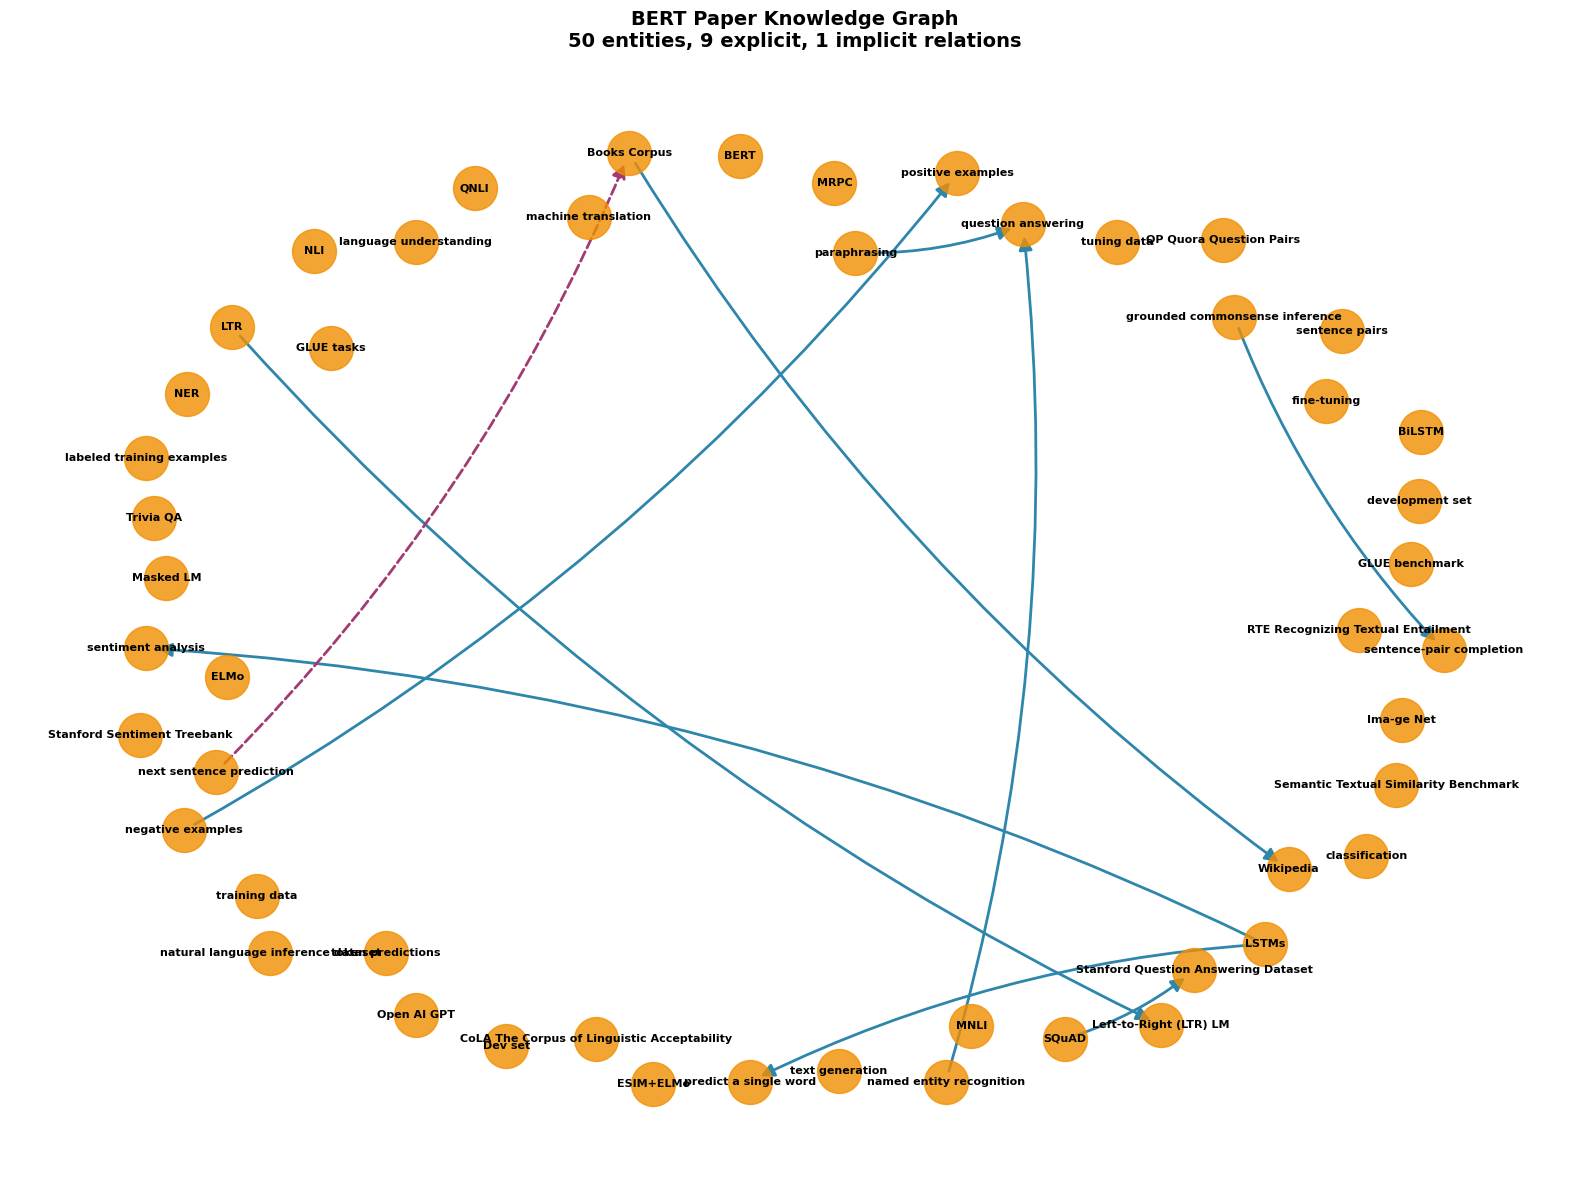

In [73]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

entity_set = {e['text'] for e in filtered_entities}

for e in filtered_entities:
    G.add_node(e['text'], type=e['type'], score=e.get('pr_score', 0))

for rel in explicit_relations:
    G.add_edge(rel.e1, rel.e2, 
               relation=rel.rel_type, 
               confidence=rel.confidence,
               edge_type='explicit')

for rel in high_quality_implicit:
    if rel.e_i in entity_set and rel.e_j in entity_set:
        G.add_edge(rel.e_i, rel.e_j,
                   confidence=rel.confidence,
                   edge_type='implicit')

print(f"Knowledge graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

pos = nx.spring_layout(G, k=2, iterations=50, seed=42)

plt.figure(figsize=(16, 12))

explicit_edges = [(u, v) for u, v, d in G.edges(data=True) 
                  if d.get('edge_type') == 'explicit']
implicit_edges = [(u, v) for u, v, d in G.edges(data=True) 
                  if d.get('edge_type') == 'implicit']

nx.draw_networkx_edges(G, pos, edgelist=explicit_edges, 
                       edge_color='#2E86AB', width=2, 
                       arrowsize=20, connectionstyle='arc3,rad=0.1')

nx.draw_networkx_edges(G, pos, edgelist=implicit_edges, 
                       edge_color='#A23B72', width=2, 
                       style='dashed', arrowsize=20,
                       connectionstyle='arc3,rad=0.1')

nx.draw_networkx_nodes(G, pos, node_color='#F18F01', 
                       node_size=1000, alpha=0.8)

nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

plt.title(f"BERT Paper Knowledge Graph\n{G.number_of_nodes()} entities, {len(explicit_edges)} explicit, {len(implicit_edges)} implicit relations", 
          fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()

graph_path = output_dir / f"{arxiv_id}_knowledge_graph.png"
plt.savefig(graph_path, dpi=300, bbox_inches='tight')
print(f"Graph saved to: {graph_path}")

plt.show()
